# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [1]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg

In [3]:
fiducial_dir = Path(r'F:\Research\Fiducial paper analysis')

mpm_tile_path = Path(fiducial_dir, r'Metadata images\Fiducial acq 1.ome.tif')
mpm_path = Path(fiducial_dir, r'MPM Images\MPM downsampled\MPM acq 1_8x.tif')

us_path = Path(fiducial_dir, r'Ultrasound\US Rotation 1.tif')
us_pl_path = Path(r'C:\Users\mpinkert\Box\Research\LINK\Phantom Trials\2019-05-04\2019-05-04_US - 3X 100YSep.pos')
us_height = 0
dynamic_range = 50

Open the images

In [4]:
mpm_image = coord.open_microscopy(mpm_path, mpm_tile_path, downsample_factor=8)

In [5]:
us_image = coord.open_us(us_path, us_pl_path, dynamic_range, us_height)

c:\users\mpinkert\documents\github\multiscale\multiscale\microscopy\ome.py:81: UserWarning: Could not read the spacing.  Spacing has been set to 1, 1, 1.  Fix manually
  warnings.warn('Could not read the spacing.  Spacing has been set to 1, 1, 1.  Fix manually', )


In [6]:
us_image.SetSpacing([25, 25, 25])

Acquire similar points between images

<IPython.core.display.Javascript object>


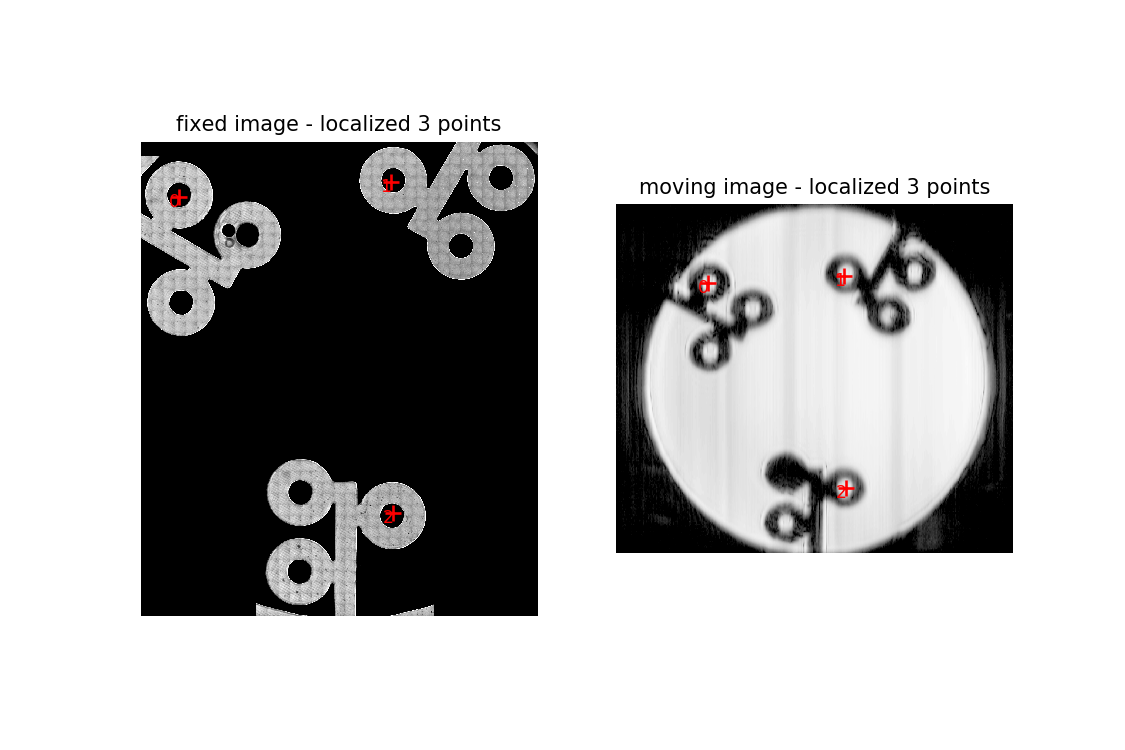

In [7]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [8]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [9]:
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)
final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [10]:
centroid = coord.calculate_centroid(us_image[:, :, 40:165])

Threshold used: 52.0


In [11]:
fiducial_bottom = np.mean(centroid)

# -4 * 25 because the fiducial first fully appears on the fifth slice of the first MPM image
z_translation = fiducial_bottom - (mpm_image.GetOrigin()[2] - 4*25)

In [12]:
coordinate_transform = np.array(final_params)
coordinate_transform[5] = z_translation
print('Final coordinate transform: {}'.format(coordinate_transform))

Final coordinate transform: [-1.82700026e-04  8.07198207e-04 -4.02156804e-04  4.57785818e+03
  1.66239152e+03 -9.24803961e+02]


In [13]:
# Save the results
coordinate_path = Path(fiducial_dir, 'Single registration coordinate transform.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)